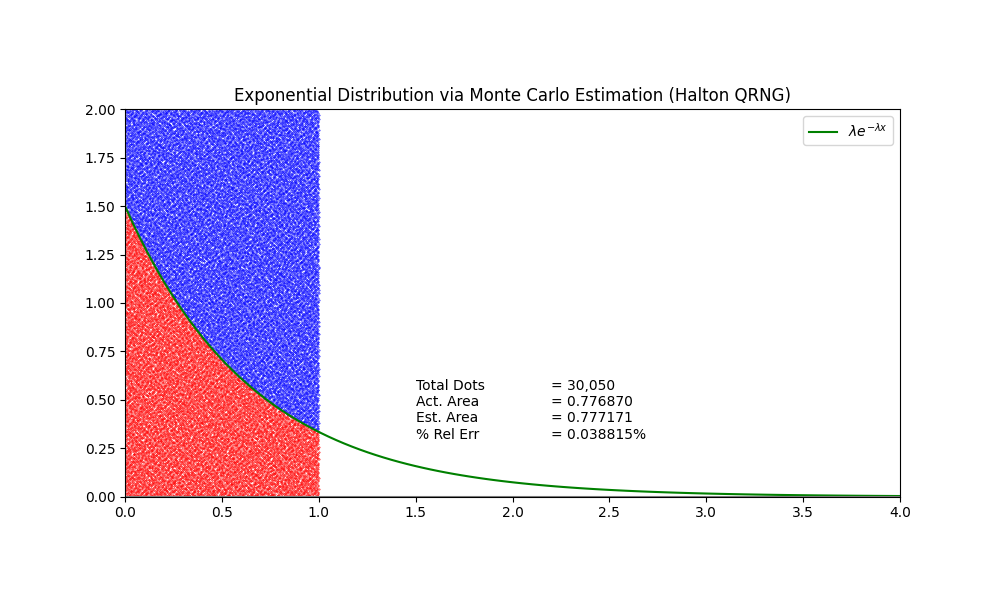

In [15]:
"""mc_exp_dist.py"""
# Cell 1

# Refrenced Dr. Biersach's code for much of the plotting portion

from __future__ import annotations

import typing

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import MarkerStyle
from matplotlib.patches import Rectangle
from numba import float64, vectorize  # type: ignore
from scipy.integrate import quad #type: ignore

if typing.TYPE_CHECKING:
    from matplotlib.axes import Axes
    from numpy.typing import NDArray

%matplotlib widget

# Exponential Distribution obtained from
# https://en.wikipedia.org/wiki/Exponential_distribution
def f(x: np.float_, rate: float) -> NDArray[np.float_]: 
    return rate * np.exp(-rate * x)
    
def plot_exponential(ax: Axes) -> None: 
    """ The function will plot the Halton QRNG rectangle to estimate the probability 
    an event will occur within an hour. Furthermore, it will plot the exponential 
    distribution with a rate parameter of 90 minutes """

    # Number of iterations. Cannot set samples too large 
    # as it will amplify differences and yield a worse % error. 
    # 30_050 produces a small amount of error
    iterations: int = 30_050
    
    # Rate parameter 90 minutes to hours
    rate: int = 1.5
    
    # Syntax for rectangle obtained from 
    # https://www.geeksforgeeks.org/matplotlib-patches-rectangle-in-python/
    # "(0,0)" defines the lower left point xy coordinate the rectangle begins which is the origin
    # 1 is the width, and 2 is the height
    rectangle = Rectangle((0,0), 1, 2)

    # Prime numbers are important for high-quality random numbers
    primes: list[int] = [2, 3]

    # Constraining x, y's sample space. Obtained from Dr. Biersach's Solution
    x: NDArray[np.float_] = rectangle.get_x() + \
        halton(np.arange(iterations), primes[0]) * rectangle.get_width()  # type: ignore
    y: NDArray[np.float_] = rectangle.get_y() + \
        halton(np.arange(iterations), primes[1]) * rectangle.get_height()  # type: ignore


    # Constraining Monte Carlo dots to be respectively above and under the PDF
    d: NDArray[np.float_] = f(x, rate) - y
    x_in: NDArray[np.float_] = x[d >= 0.0]
    y_in: NDArray[np.float_] = y[d >= 0.0]
    x_out: NDArray[np.float_] = x[d < 0.0]
    y_out: NDArray[np.float_] = y[d < 0.0]

    # Plotting the curve using Monte Carlo
    pixel_size: float = (72 / ax.figure.dpi) ** 2  # type: ignore
    ax.scatter(x_in, y_in, color="red", marker=MarkerStyle("."), s=pixel_size)
    ax.scatter(x_out, y_out, color="blue", marker=MarkerStyle("."), s=pixel_size)

    # Plotting the pdf curve
    act_x: NDArray[np.float_] = np.linspace(0, 4, 100)
    act_y: NDArray[np.float_] = f(act_x, rate)
    ax.plot(
        act_x, act_y, color="green", label=r"$\lambda e^{- \lambda x}$"
    )

    # Calculating the error from area of the rectangle and estimated area
    est_area: float = np.count_nonzero(d >= 0.0) / iterations \
        * rectangle.get_width() * rectangle.get_height()
    act_area: float = quad(f, rectangle.get_x(), rectangle.get_width(), args=(rate))[0] #type: ignore
    err: float = (est_area - act_area) / act_area #type: ignore

    # addiing text annotations to the plot that convey key information
    ax.text(1.5, 0.3, "Total Dots\nAct. Area\nEst. Area\n% Rel Err", ha="left")
    # fmt: off
    ax.text(2.2, 0.3,
        f"= {iterations:,}\n= {act_area:.6f}\n= {est_area:.6f}\n= {err:.6%}", ha="left")
    # fmt: on

    # Customizing the Plot
    ax.set_title("Exponential Distribution via Monte Carlo Estimation (Halton QRNG)")
    ax.set_xlim(0, 4)
    ax.set_ylim(0, 2)
    ax.axhline(0, color="gray")
    ax.axvline(0, color="gray")
    ax.set_aspect("equal")
    ax.legend(loc="upper right")
    
# Halton QRNG function obtained from Dr. Biersach
@vectorize([float64(float64, float64)], nopython=True)  # type: ignore
def halton(n: float, p: int) -> float:
    h = 0
    f = 1
    while n > 0:
        f: float = f / p
        h += (n % p) * f
        n = int(n / p)
    return h

def main() -> None:
    plt.close("all")
    plt.figure(" ", figsize=(10, 6))
    plot_exponential(plt.axes())
    plt.show()

main()